# [IAPR][iapr]: Lab 2 ‒  Object description


**Group ID:** 50

**Author 1 (sciper):** Adrien Boschung (327221)  
**Author 2 (sciper):** Louis Cuendet (345298)   
**Author 3 (sciper):** Timur Ünver (341178)   

**Release date:** 26.03.2025  
**Due date:** 09.04.2025 (11:59 pm)


## Key Submission Guidelines:

- **Before submitting your notebook, <span style="color:red;">rerun</span> it from scratch!** Go to: `Kernel` > `Restart & Run All`  
- **Only groups of three will be accepted**, except in exceptional circumstances.  
- **You are not allowed to use any libraries** other than those provided in this notebook.  
- **TAs must be able to run your code from start to finish without any issues.**  
- **Failure to follow these guidelines may result in point deductions** during grading.  


[iapr]: https://github.com/LTS5/iapr2025

In [1]:
######################################################
############ Check it is python 3.9 ##################
## DO NOT COMMENT, WE WILL TEST YOUR CODE WITH 3.9 ###
######################################################

import sys 
assert (sys.version_info.major == 3) and (sys.version_info.minor == 9)

AssertionError: 

In [ ]:
# Install required packages
!pip install wget -q
!pip install numpy -q
!pip install matplotlib -q
!pip install scikit-image -q
!pip install scikit-learn -q
!pip install python-mnist -q
!pip install opencv-python -q

In [2]:
# Import main packages
from utils.lab_02_utils import *
from skimage.morphology import remove_small_objects, remove_small_holes, closing, disk, opening
from skimage.transform import rotate, resize
from sklearn.metrics.pairwise import euclidean_distances
from skimage.measure import regionprops

import cv2
import numpy as np

c:\Installation\Anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


---
# Introduction

In this lab, we will work with the famous MNIST dataset. It is composed of thousands of images (size 28x28) that depict handwritten digits from 0 to 9. The code below will automatically download the data from the online repo. This lab aims to create discriminant features from handwritten digits using various approaches. 


Take a look at the data to get a better idea of what you will be working within this lab.

Data downloaded under folder: ..\data\data_lab_02
60000 Images and 60000 labels loaded


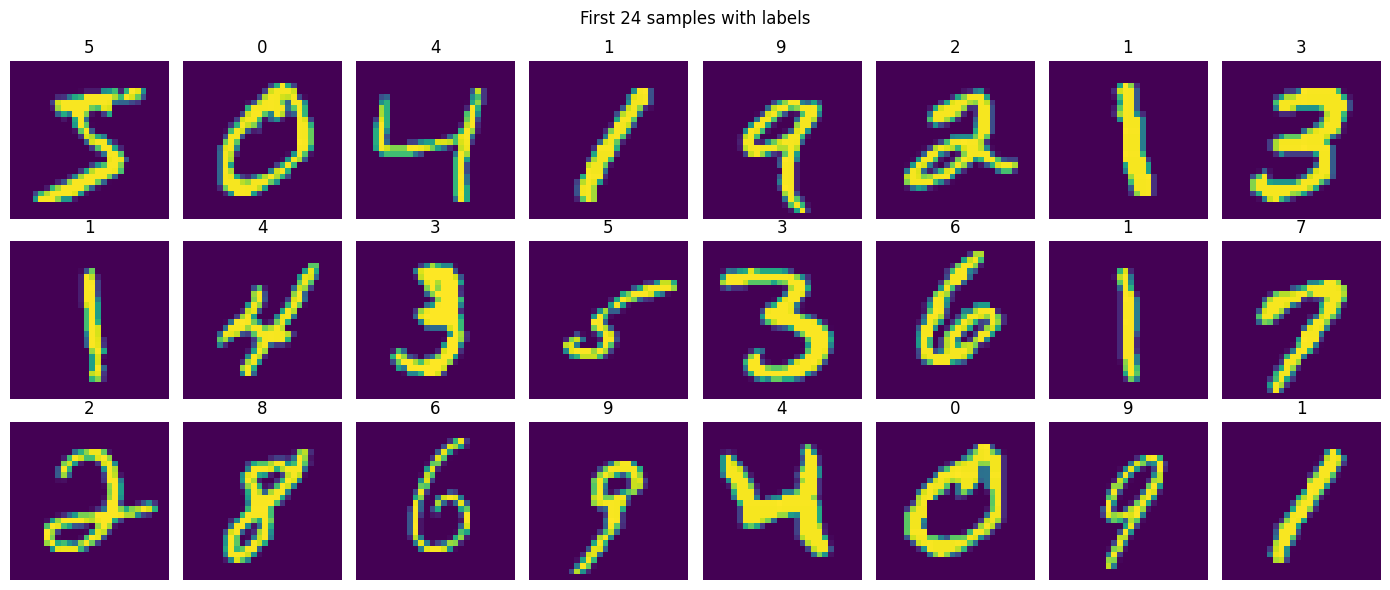

In [3]:
images, labels = load_lab02_data()

---
# Part 1 - Preprocessing [2 pts]


In this lab, we will create different feautre descriptors from digits. However, we will not use all images in the dataset. We will focus on the digits "0" and "4".

## 1.1 Selection (1 pt)

**Q1 (1 pt)** Your first task is to complete the function `extract_label` such that it selects from the input data only the images that are labeled as a given `target_label`. This function will be used to extract 0s and 4s from the data cohort. When running the code, the plots should only show you samples that are 0s (first plot) and 4s (second plot)

In [4]:
def extract_label(images: np.ndarray, labels: np.ndarray, target_label: int):
    """
    The function returns only the images that have target_label as labels.
    
    Args
    ----
    images: np.ndarray (N, 28, 28)
        Source images - handwritten digits 
    labels: np.ndarray (N)
        List of labels associated with the input image
    target_label: int
        Selected target label

    Return
    ------
    img_extract: np.ndarray (M, 28, 28)
        Extracted images that have target_label as label (M should be lower than N).
    """

    n, d, _ = np.shape(images) 
    img_extract = np.zeros((30, d, d)) 

    # ------------------
    j = 0
    for i in range(len(images)) :
        if labels[i] == target_label :
            if j == 30 :
                break
            img_extract[j, :, :] = images[i, :, :]
            j += 1

    #img_extract = images[labels == target_label,:,:]
    # ------------------
    
    return img_extract

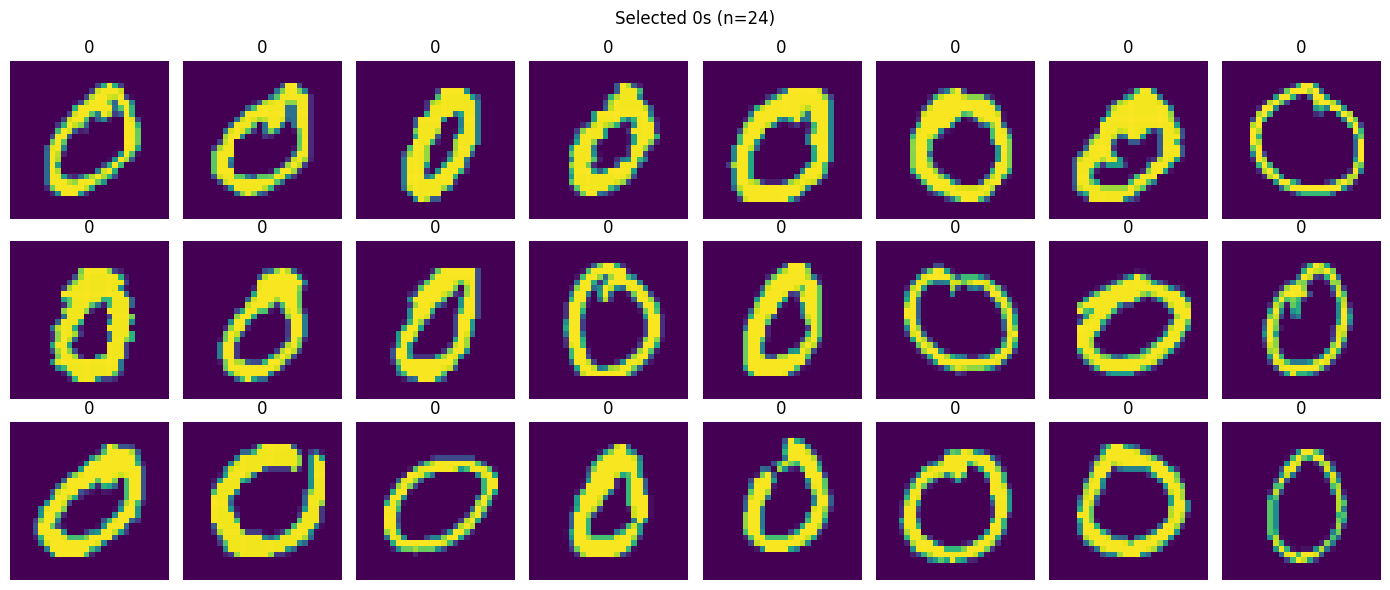

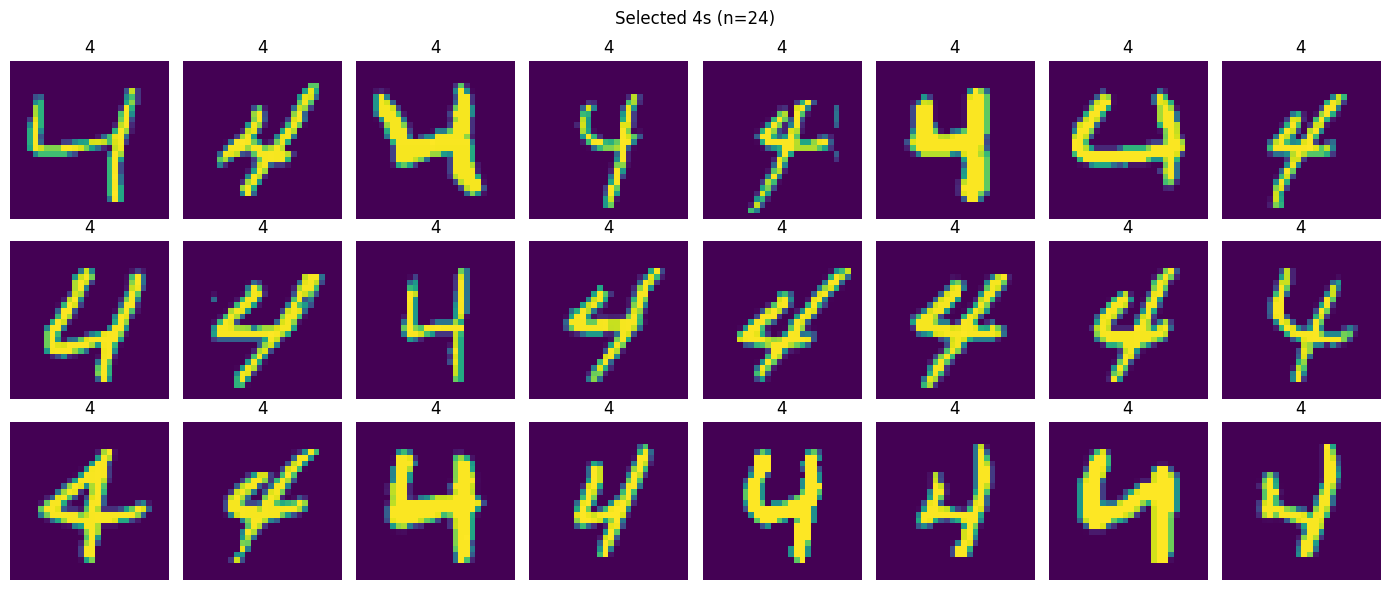

In [5]:
################################################################
############################ TEST ##############################
################################################################

images_a, images_b = test_1_1(extract_label, images, labels)

## 1.2 Preprocessing (1 pt)

Before computing the Fourier descriptors we need to preprocess the images.

* **Q1 (1 pt)**: Complete the function `preprocess` such that it cleans the input images. Take a look at the example images above and try to think what could be improved to allow better uniformity of the data. Take advantage of what you have learned in the previous lab.

In [6]:
def apply_closing(img, disk_size):
    """
    Apply closing to input mask image using disk shape.

    Args
    ----
    img : np.ndarray (M, N)
        Image mask of size MxN.
    disk_size: int
        Size of the disk to use for opening

    Return
    ------
    img_closing: np.ndarray (M, N)
        Image after closing operation
    """

    # Define default value for output image
    img_closing = np.zeros_like(img )

    # ------------------
    dk=disk(disk_size)
    img_closing = closing(img , dk)
    # ------------------

    return img_closing


def apply_opening(img , disk_size):
    """
    Apply opening to input mask image using disk shape.

    Args
    ----
    img : np.ndarray (M, N)
        Image mask of size MxN.
    disk_size: int
        Size of the disk to use for opening

    Return
    ------
    img_opening: np.ndarray (M, N)
        Image after opening operation
    """

    # Define default value for output image
    img_opening = np.zeros_like(img )

    # ------------------
    dk=disk(disk_size)
    img_opening = opening(img , dk) 
    # ------------------

    return img_opening

def remove_holes(img , size):
    """
    Remove holes from input image that are smaller than size argument.

    Args
    ----
    img : np.ndarray (M, N)
        Image mask of size MxN.
    size: int
        Minimal size of holes

    Return
    ------
    img_holes: np.ndarray (M, N)
        Image after remove holes operation
    """

    # Define default value for input image
    img_holes = np.zeros_like(img )

    # ------------------
    img_holes = remove_small_holes(img , size)
    # ------------------

    return img_holes


def remove_objects(img , size):
    """
    Remove objects from input image that are smaller than size argument.

    Args
    ----
    img : np.ndarray (M, N)
        Image mask of size MxN.
    size: int
        Minimal size of objects

    Return
    ------
    img_obj: np.ndarray (M, N)
        Image after remove small objects operation
    """

    # Define default value for input image
    img_obj = np.zeros_like(img )

    # ------------------
    img_obj = remove_small_objects(img , size)
    # ------------------

    return img_obj

In [7]:
def preprocess(images: np.ndarray):
    """
    Apply the processing step to images to achieve better data uniformity.
    
    Args
    ----
    images: np.ndarray (N, 28, 28)
        Source images

    Return
    ------
    img_process: np.ndarray (N, 28, 28)
        Processed images.
    """

    # Get the shape of input data and set dummy values
    n, d, _ = np.shape(images) 
    img_process = np.zeros_like(images)
    
    # ------------------
    """ for i in range(n):
        img = images[i, :, :]
        img = img > 0
        img = remove_small_objects(img , 50)
        #img  = opening(img)
        #img  = closing(img)
        #img  = remove_holes(img , 10)
        #img  = remove_objects(img , 10)

        img_process[i, :, :] = img  """

        #remove_small_objects, remove_small_holes, closing, disk, opening

    for i in range(n):
        # Transform image to binary
        img = images[i] > 120
        
        # Store processed image
        img_process[i,:,:] = img
    # ------------------

    return img_process

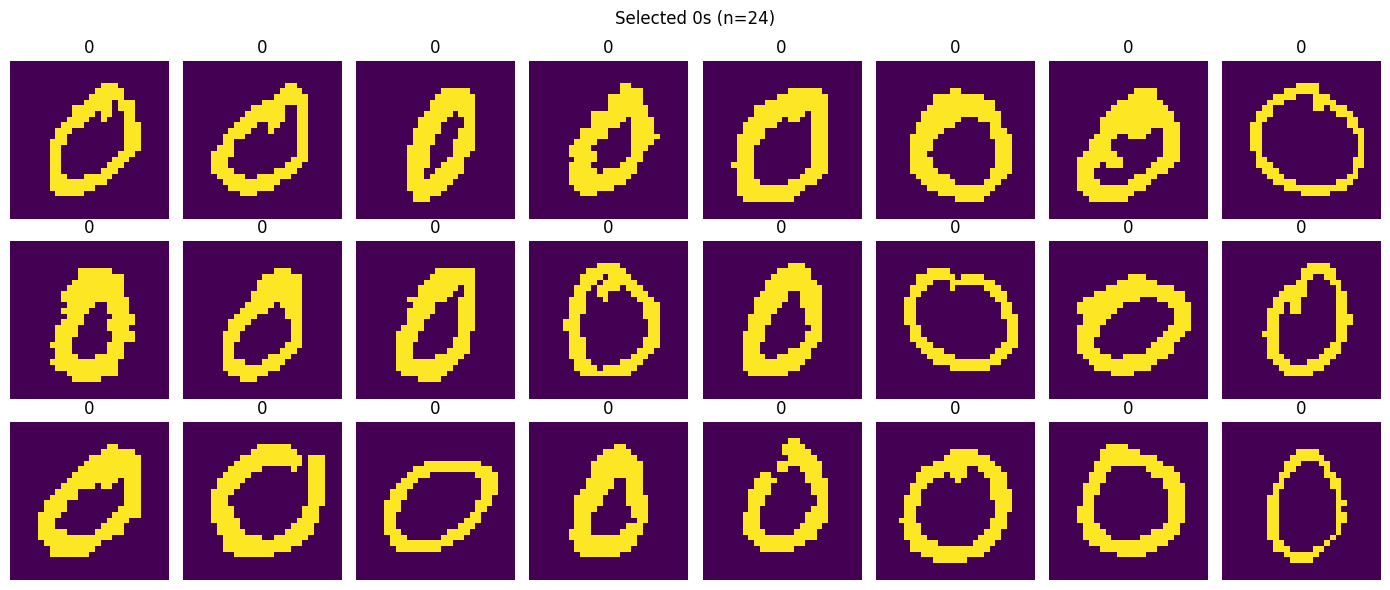

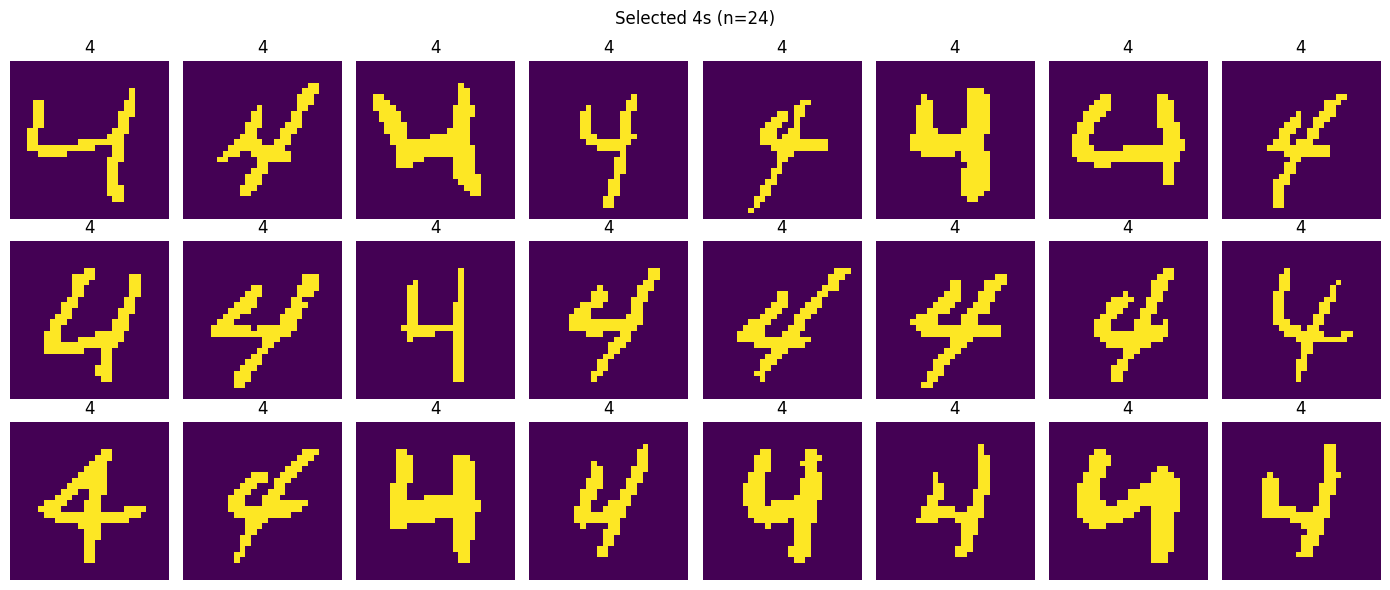

In [8]:
################################################################
############################ TEST ##############################
################################################################

images_p_a, images_p_b = test_1_2(preprocess, images_a, images_b)

---
# Part 2 - Fourier Descriptors [17 pts]


## 2.1. Get contour and descriptors (9 pts)

In this section, we will create Fourier descriptors from digits. The next step in our pipeline will be to detect the contours. To do so you can use existing algorithm available online such as `find_contours`([doc](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.find_contours)) from skcit-image or `findContours` ([doc](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0)) from opencv. Pay attention to the coordinate system when using the contour detection function (is the first component x or y coordinate?).

* **Q1 (2 pts)**: Complete the function `find_contour` below such that it returns the contour estimations of the given images. The provided `display_samples` function will display the returned contours for a subset of images.

In [9]:
from skimage.measure import find_contours
def find_contour(images: np.ndarray):
    """
    Find the contours for the set of images
    
    Args
    ----
    images: np.ndarray (N, 28, 28)
        Source images to process

    Return
    ------
    contours: list of np.ndarray
        List of N arrays containing the coordinates of the contour. Each element of the 
        list is an array of 2d coordinates (K, 2) where K depends on the number of elements 
        that form the contour. 
    """

    # Get number of images to process
    N, _, _ = np.shape(images)
    # Fill in dummy values (fake points)
    contours = [np.array([[0, 0], [1, 1]]) for i in range(N)]

    # ------------------
    for i in range(N):
        contour = find_contours(images[i, :, :])
        contours[i] = np.flip(contour[0]) 
    # ------------------
    
    return contours
    

30


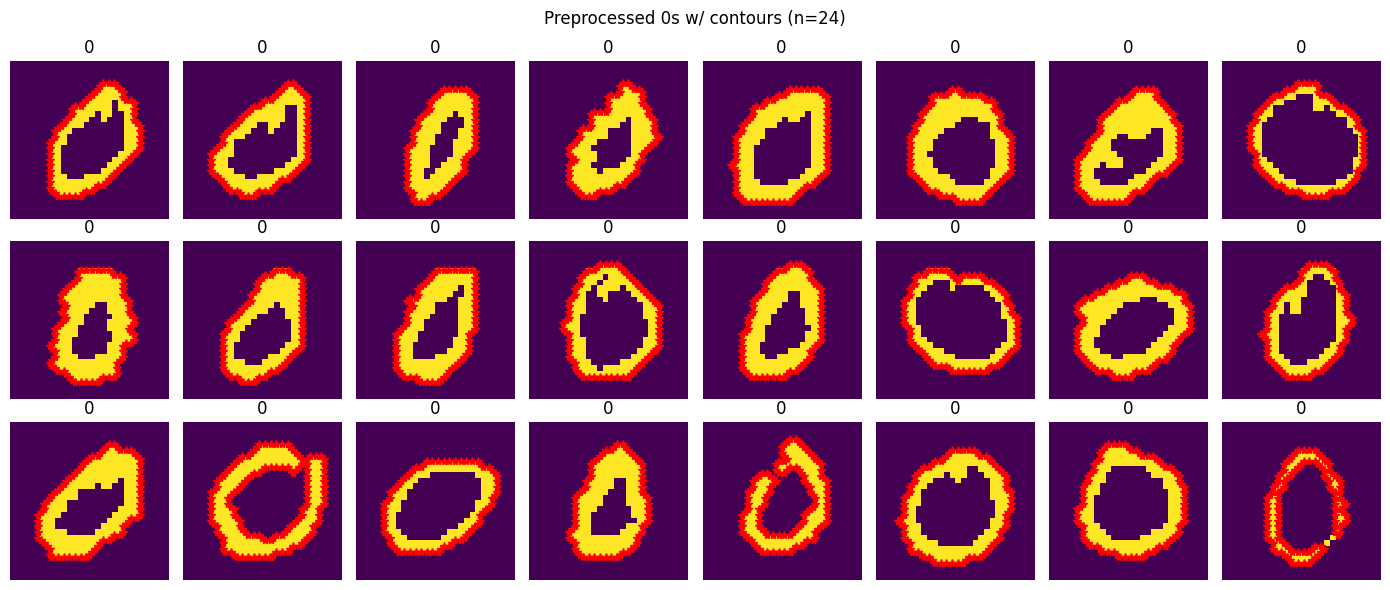

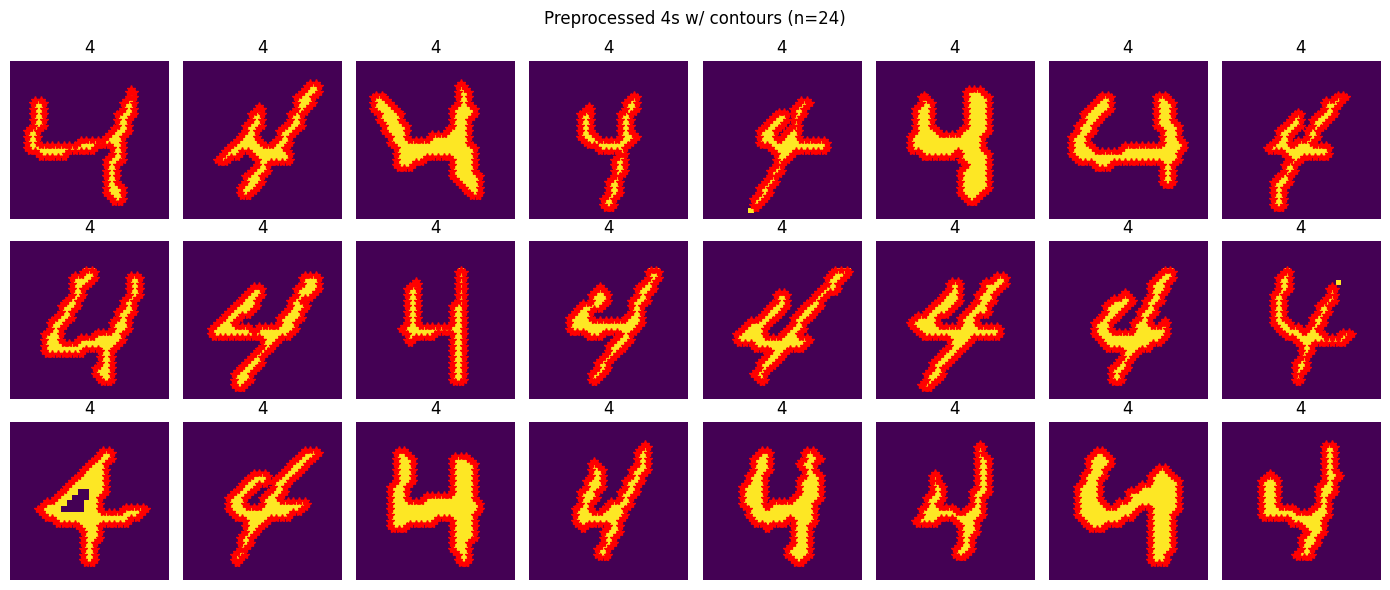

In [10]:
################################################################
############################ TEST ##############################
################################################################

cnt_p_a, cnt_p_b = test_2_1(find_contour, images_p_a, images_p_b)


Now that we are able to properly detect shape contours, we can finally compute Fourier descriptors. However, we still face a small issue. The allow a fair comparison between the Fourier descriptors we need to ensure that all descriptors have the same length.

* **Q2 (2 pts)**: Implement the function `compute_descriptor_padding` that takes as input the computed contours from before and returns the Fourier descriptors for each contour. Use `fft` ([doc](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html#numpy.fft.fft)) from Numpy to compute the transformation. Use the `n_sample` argument to set the number of points to consider per contour. If the contour is longer than `n_sample` discard the extra points. If the contour is shorter than `n_sample`, use 0 paddings. Make sure that the first element of the descriptor represent the continuous component in the frequency domain.

In [11]:
def compute_descriptor_padding(contours: np.ndarray, n_samples: int = 11):
    """
    Compute Fourier descriptors of input images
    
    Args
    ----
    contours: list of np.ndarray
        List of N arrays containing the coordinates of the contour. Each element of the 
        list is an array of 2d coordinates (K, 2) where K depends on the number of elements 
        that form the contour. 
    n_samples: int
        Number of samples to consider. If the contour length is higher, discard the remaining part. If it is shorter, add padding.
        Make sure that the first element of the descriptor represents the continuous component.

    Return
    ------
    descriptors: np.ndarray complex (N, n_samples)
        Computed complex Fourier descriptors for the given input images
    """

    N = len(contours)
    # Look for the number of contours
    descriptors = np.zeros((N, n_samples), dtype=np.complex128)

    # ------------------
    for i in range(N):
        contour = contours[i]
        if len(contour) > n_samples:
            contour = contour[:n_samples]
        elif len(contour) < n_samples:
            contour = np.concatenate((contour, np.zeros((n_samples - len(contour), 2))), axis=0)
        descriptors[i, :] = np.fft.fft(contour[:, 0] + 1j * contour[:, 1], n_samples)
    # ------------------

    return descriptors


The code below uses the `plot_features` function to display the computed Fourier descriptors. We display the real, imaginary, and absolute components, respectively. Each color depicts a different digit. We use 2D plots to highlight the clustering capability of the components.
* **Q3 (1 pt)**: Comment on the quality of the Fourier descriptors. Do you think they are good feature descriptors? (justify)
    * **Answer**: It is hard to find a component which clearly separates both digits into two distinct groups. There are always many outliers which make the decision making difficult or the features are stacked together.
* **Q4 (1 pt)**: Knowing that we used `n_samples=11` to compute the Fourier transform, what do the components 0, 1, 5, and 10 represent as frequencies? (high, medium, constant, etc.)
    * **Answer**: Low components represent low frequencies and higher components higher frequencies. Therefore 0 is the constant term, 1 the low frequency component, 5 the medium frequency component and 10 the high frequency component.

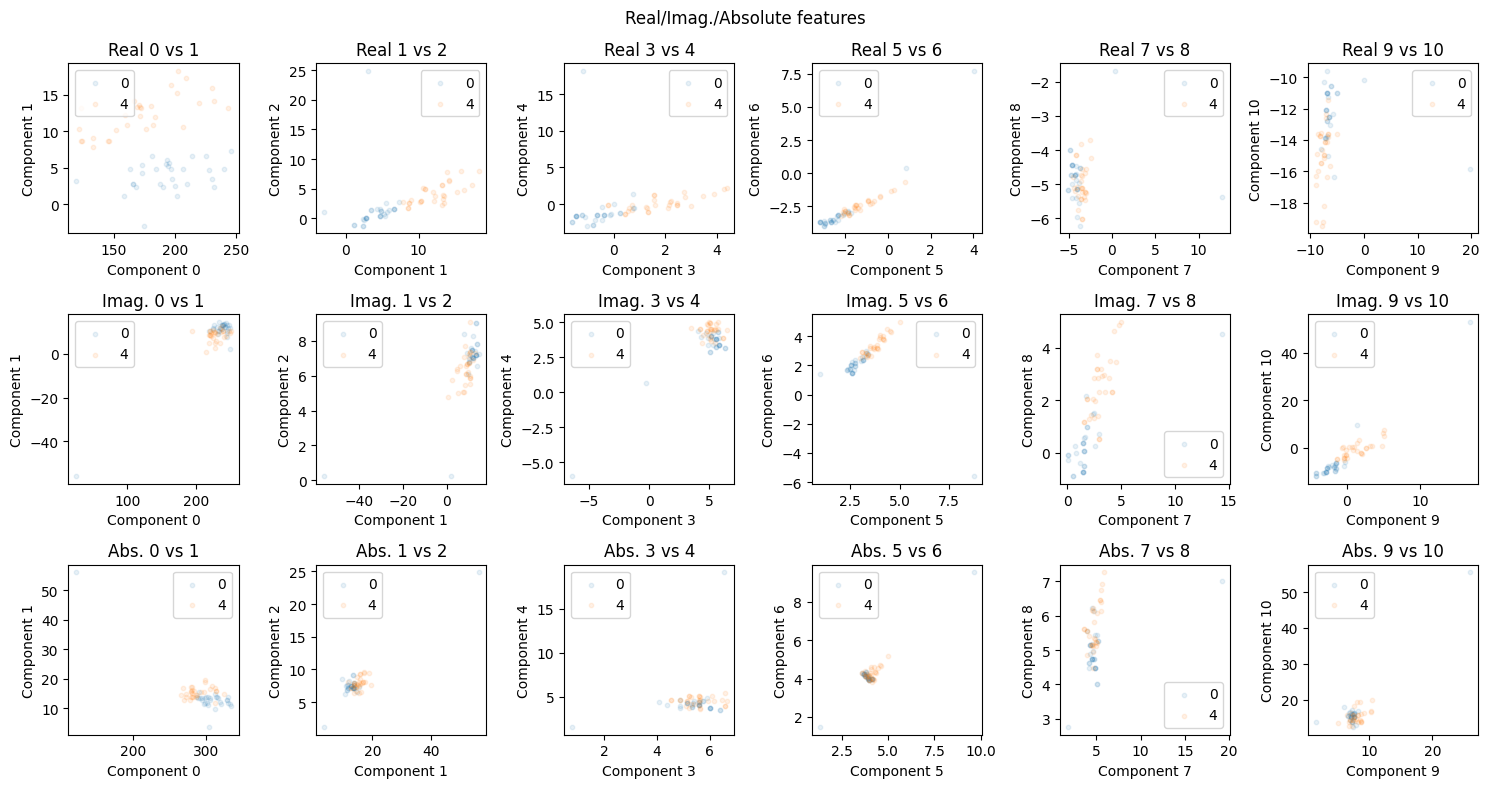

In [12]:
################################################################
############################ TEST ##############################
################################################################

test_2_1_2(compute_descriptor_padding, cnt_p_a, cnt_p_b)

As you might have realized before, the computed Fourier descriptors do not help us to find an optimal separation between the digits. This mainly comes from the fact that using 0 padding is a cheap and inefficient way to ensure homogeneity in length for descriptors. A better solution would be to ensure that we have the same number of points along the contour for each digit. To do so, we need to implement a new function that will resample the contour such that we always have the same number of points no matter the shape.

* **Q5 (2 pts)**: Implement the function `linear_interpolation` that takes as input the contours with various lengths and the wanted number of samples per contour for resampling. For each contour, resample the points such that each contour has the same length `n_samples`. We want the points to be uniformly distributed (same distance between points) along the contour. You can use for example the function `interp` ([doc](https://numpy.org/doc/stable/reference/generated/numpy.interp.html)) from Numpy to perform the interpolation. The function `display_samples` will display the contour for different lengths.

**Hint**: Think about the contour as two distinct signals x(t) and y(t) that are evaluated at different time steps $t$. Here the time steps can be seen as the Euclidean distance between consecutive samples $t_i$ = $ \sum_{j=1}^{j \leq i} \sqrt{(x_{j} - x_{j-1})^2 + (y_{j} - y_{j-1})^2}$, and $t_0 = 0$. The aim here is to resample the function at new time steps $t_i' = i * \frac{t_{N-1}}{n_{samples} + 1}$ where $n_{samples}$ is the new number of points.

In [17]:
def linear_interpolation(contours: np.ndarray, n_samples: int = 11):
    """
    Perform interpolation/resampling of the contour across n_samples.
    
    Args
    ----
    contours: list of np.ndarray
        List of N arrays containing the coordinates of the contour. Each element of the 
        list is an array of 2d coordinates (K, 2) where K depends on the number of elements 
        that form the contour. 
    n_samples: int
        Number of samples to consider along the contour.

    Return
    ------
    contours_inter: np.ndarray (N, n_samples, 2)
        Interpolated contour with n_samples
    """

    N = len(contours)
    contours_inter = np.zeros((N, n_samples, 2))
    
    # ------------------
    for i in range(N):
        # Get the contour to process
        contour = contours[i]
        # Compute the distance between points
        dist = np.sqrt(np.sum(np.diff(contour, axis=0) ** 2, axis=1))
        # Compute the cumulative distance
        cum_dist = np.concatenate(([0], np.cumsum(dist))) #with initial point at 0
        # Interpolate the points
        dist = np.linspace(0, cum_dist[-1], n_samples) #defining the distance axis (from 0 the total distance at [-1] index)
        x_interp = np.interp(dist, cum_dist, contour[:, 0]) #x as a function of distance
        y_interp = np.interp(dist, cum_dist, contour[:, 1]) #y as a function of distance
        contours_inter[i] = np.array([x_interp, 
                                      y_interp]).T #transposing to get the right shape
    # ------------------
        
    return contours_inter


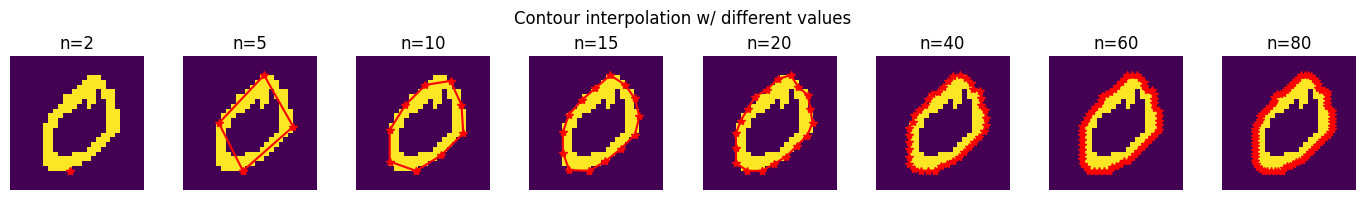

In [18]:
################################################################
############################ TEST ##############################
################################################################

test_2_1_5(linear_interpolation, cnt_p_a, images_p_a)

Now that we have implemented our resampling approach we can revisualize the clustering efficiency of our descriptors.

* **Q6 (1 pt)**: Comment on the quality of the descriptors. Is it better than before? is there a frequency/component that appears to work better? Does it make sense?
    * **Answer**: The quality is definitely improved but it is still difficult to make a decision in certain cases. Considering real and imaginary values separately can help with linearly separating the 2 different digits. Components 9 and 10 show clusters in absolute value and in the complex dimension. Components 1 and 2 in absolute value show two clusters with a large margin (though not dense) but we observe a few outliers. Same for components 7 and 8 with a reduced margin. A combination of these descriptors would likely lead to the best prediction. We expect low frequency components to show different clusters as they are the most important for signal reconstructing (general shape, ...) and we can observe it with components 1 and 2 and the large margin between the clusters (ignoring the outliers).

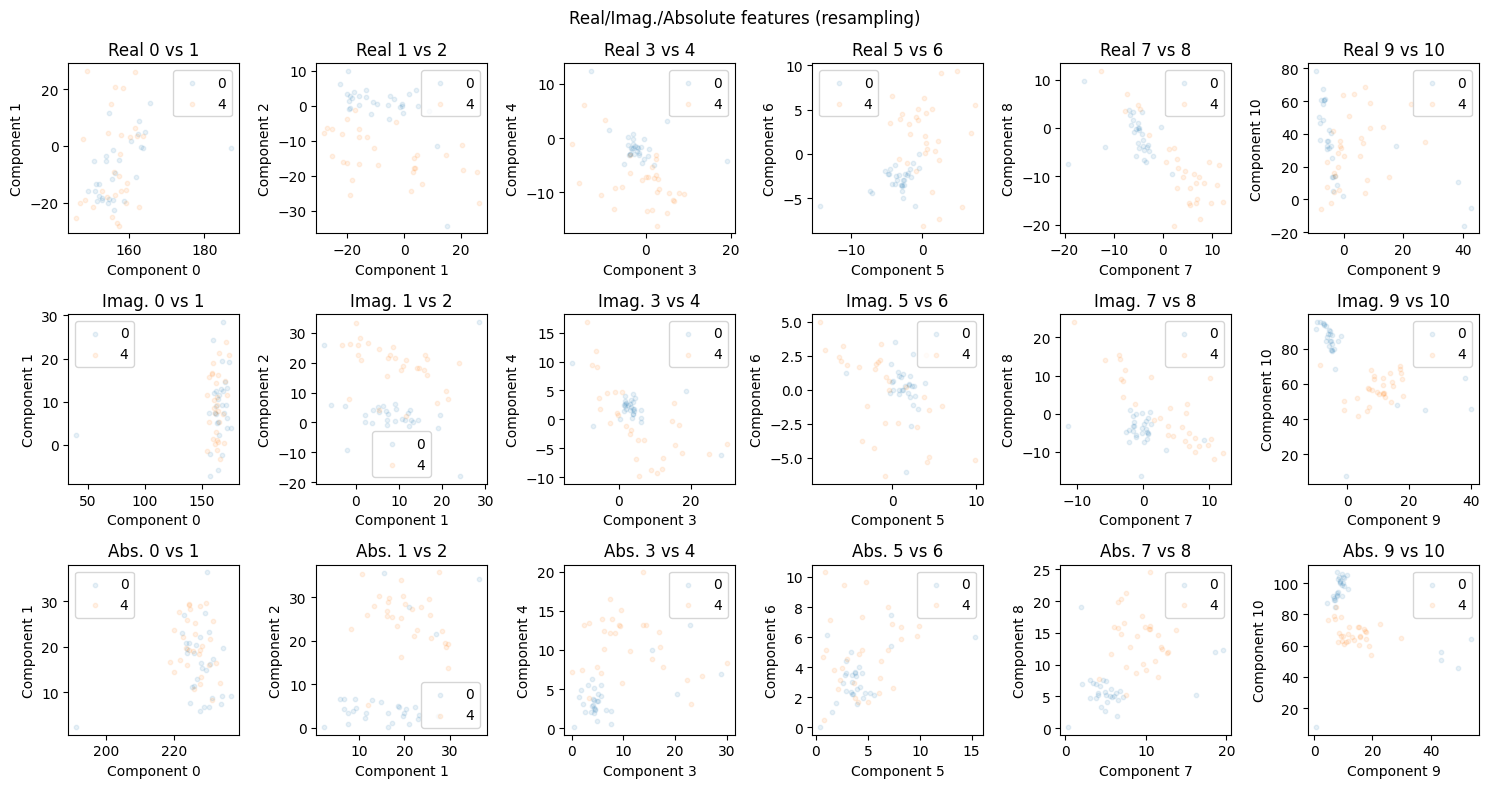

In [20]:
################################################################
############################ TEST ##############################
################################################################

feat_a, feat_b = test_2_1_6(compute_descriptor_padding, linear_interpolation, cnt_p_a, cnt_p_b, n_samples=11)

## 2.2. Reconstruction (2 pts)

For this part, we will now try to go the other way. Given a Fourier descriptor we will try to retrieve the original shape. 
* **Q1 (1 pt)** Implement the function `compute_reverse_descriptor` that takes as input a single descriptor and reverses it to x and y coordinates given a number of samples `n_samples`. Use the function `ifft` ([doc](https://numpy.org/doc/stable/reference/generated/numpy.fft.ifft.html)) from Numpy.

In [23]:
def compute_reverse_descriptor(descriptor: np.ndarray, n_samples: int = 11):
    """
    Reverse a Fourier descriptor to xy coordinates given a number of samples.
    
    Args
    ----
    descriptor: np.ndarray (D,)
        Complex descriptor of length D.
    n_samples: int
        Number of samples to consider to reverse transformation.

    Return
    ------
    x: np.ndarray complex (n_samples,)
        x coordinates of the contour
    y: np.ndarray complex (n_samples,)
        y coordinates of the contour
    """

    x = np.zeros(n_samples)
    y = np.zeros(n_samples)
    
    # ------------------
    x = np.real(np.fft.ifft(descriptor))
    y = np.imag(np.fft.ifft(descriptor))
    # ------------------

    return x, y


With the function `plot_reconstruction` we plot an example of the reconstruction of the digits. We display the result as we progressively add more frequencies. We start with the first component (component 0) and then add frequency pairs from low to high frequencies.

* **Q2 (1 pt)**: Based on your observation, do you think 11 samples are enough to properly describe the digits below? (justify)
    * **Answer**: For these examples, 11 samples are enough to distinguish a 0 and a 4 as the shapes represent the number well. But for some other examples where the numbers are a bit oddly represented or if we add more digits to recognize it might not be enough.

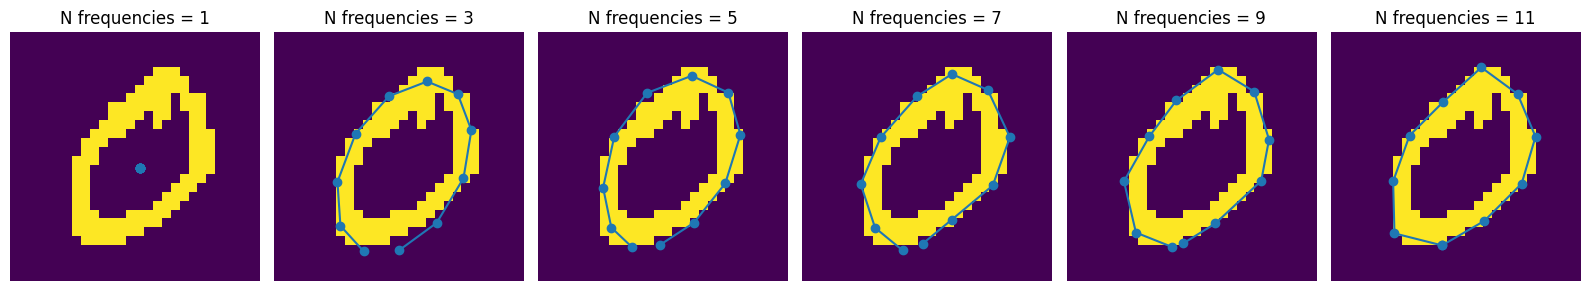

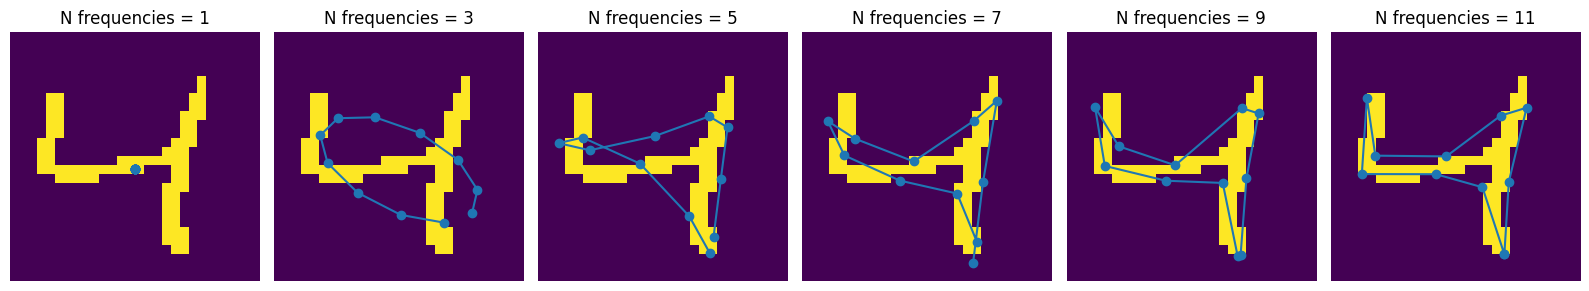

In [24]:
################################################################
############################ TEST ##############################
################################################################

test_2_2(images_p_a , images_p_b, feat_a, feat_b, compute_reverse_descriptor)

## 2.3. Invariance (6 pts)

For the last part with Fourier descriptors, we will check for descriptors invariance. As seen in class, if handled properly Fourier descriptors can be invariant to translation, rotation, and scaling.

* **Q1 (3 pts)**: Implement the functions `apply_rotation`, `apply_scaling`, and `apply_translate` to apply random rotation, scaling, and translation to input images. For scaling and translation, we recommend avoiding large values where the digits are cropped (out of frame). You can use the `random` package ([doc](https://numpy.org/doc/1.16/reference/routines.random.html)) from Numpy to generate random values.

In [25]:
def apply_rotation(img: np.ndarray):
    """
    Apply random rotation to input the image
    
    Args
    ----
    image: np.ndarray (28, 28)
        Source images
        
    Return
    ------
    rotated: np.ndarray (28, 28)
        Rotated source images
    """

    rotated = np.zeros_like(img)
    
    # ------------------
    # Get the random angle
    angle = np.random.randint(0, 360)
    # Rotate the image
    rotated = rotate(img, angle) #image will stay binary if angle is 0
    # ------------------
    
    return rotated


def apply_scaling(img: np.ndarray):
    """
    Apply random scaling to input image
    
    Args
    ----
    image: np.ndarray (28, 28)
        Source images
        
    Return
    ------
    scaled: np.ndarray (28, 28)
        Scaled source images
    """
    
    scaled = np.zeros_like(img)
    
    # ------------------
    # Get the random size
    size = np.random.randint(1, 38)
    # Resize the image
    resized = resize(img, (size, size)) #image will stay binary if size is the same
    # Get the center of the image
    center = (size // 2, size // 2)
    # Place resized image in the center of the sclaled image
    if size > 28:
        scaled = resized[center[0] - 14:center[0] + 14, center[1] - 14:center[1] + 14]
    elif size % 2 == 0:
        scaled[14 - center[0]:14 + center[0], 14 - center[1]:14 + center[1]] = resized
    else:
        scaled[14 - center[0]:14 + center[0] + 1, 14 - center[1]:14 + center[1] + 1] = resized
    # ------------------

    return scaled

def apply_translate(img: np.ndarray):
    """
    Apply random x and y translation to input image
    
    Args
    ----
    image: np.ndarray (28, 28)
        Source images
        
    Return
    ------
    translated: np.ndarray (28, 28)
        Translated source images
    """
    
    translated = np.zeros_like(img)
    
    # ------------------
    tx = np.random.randint(-7, 7)
    ty = np.random.randint(-6, 6)
    # Create the translation matrix
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            # Translate the image
            if (x + tx) >= 0 and (x + tx) < img.shape[0] and (y + ty) >= 0 and (y + ty) < img.shape[1]:
                translated[y, x] = img[y + ty, x + tx]
            else:
                translated[y, x] = 0
    # ------------------
    
    return translated


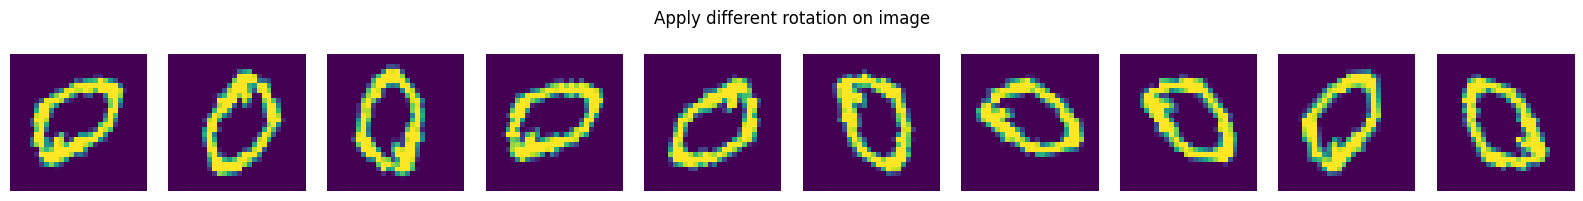

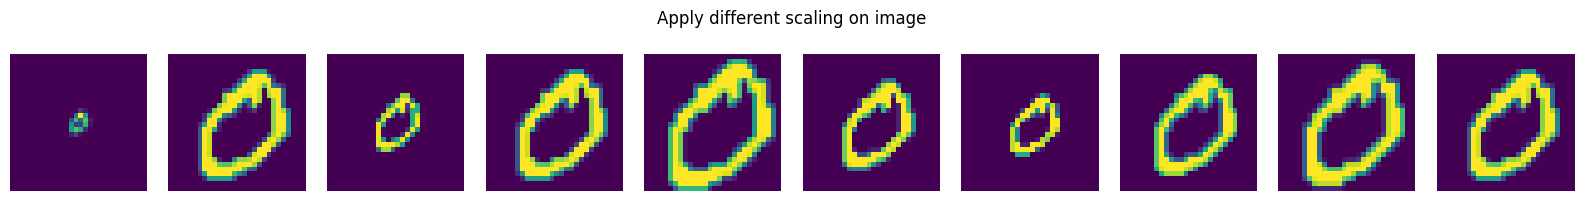

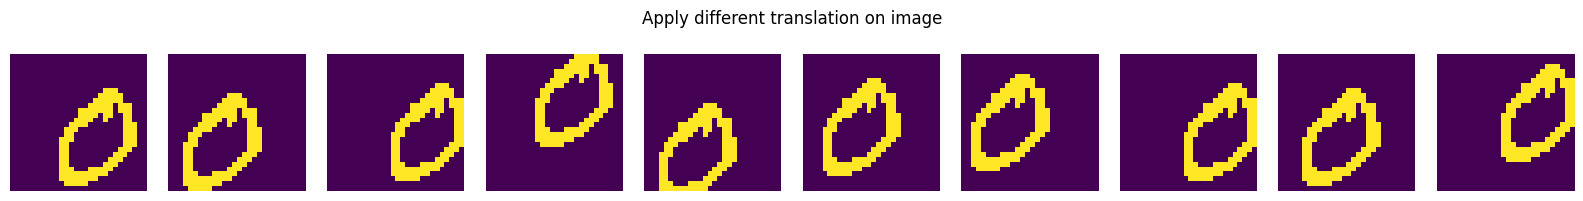

In [26]:
################################################################
############################ TEST ##############################
################################################################

test_2_3(apply_rotation, apply_scaling, apply_translate, images_p_a[0])

Now that we implemented our transformation, we can test for feature invariance. To assess the robustness of the Fourier descriptors to image transformations, we compute the error between the original descriptors (before transformation) to the one after transformation. 

* **Q2 (1 pt)**: Complet the function `translation_invariant` to make the Fourier deciptor invariant to translation. Does the error decrease after treatment for translation invariance? Is it null, if not why?
    * **Answer**: The error decrease to a value close to zero. It is not exactly null as 

In [35]:
def translation_invariant(features):
    """
    Make input Fourier descriptors invariant to translation.

    Args
    ----
    features: np.ndarray (N, D)
        The Fourier descriptors of N images over D features.

    Return
    ------
    features_inv: np.ndarray (N, K)
        The Fourier descriptors invariant to translation of N images 
        over K (K <= N) features.
    """

    # Set default values
    features_inv = np.zeros_like(features)
    
    # ------------------
    for i in range(len(features)):
        features_inv[i] = features[i]/ features[i][0] #is the centroid of contour i
    # ------------------] 
    
    return features_inv

Translation error: 16.65
Corrected translation error: 0.06


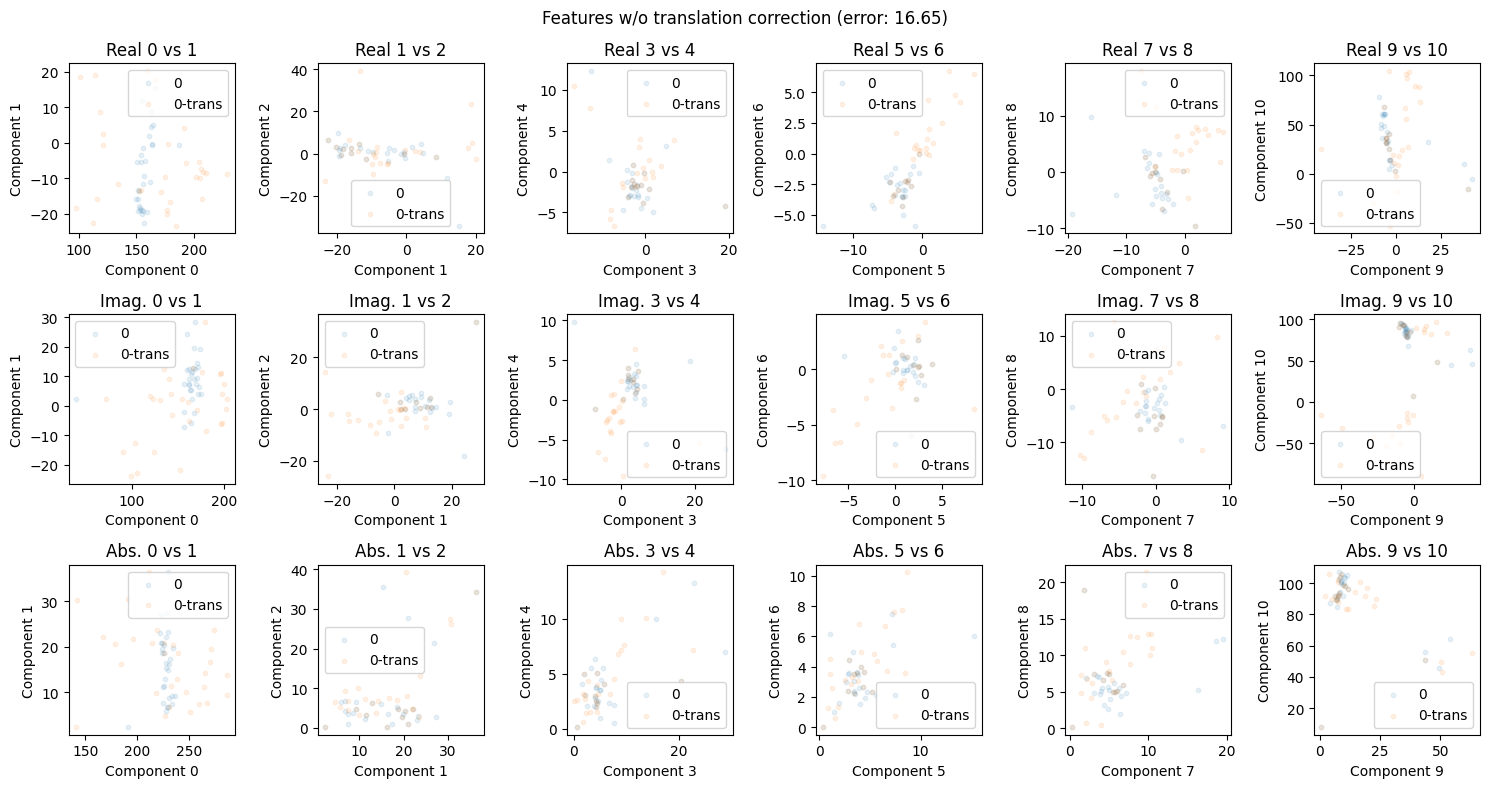

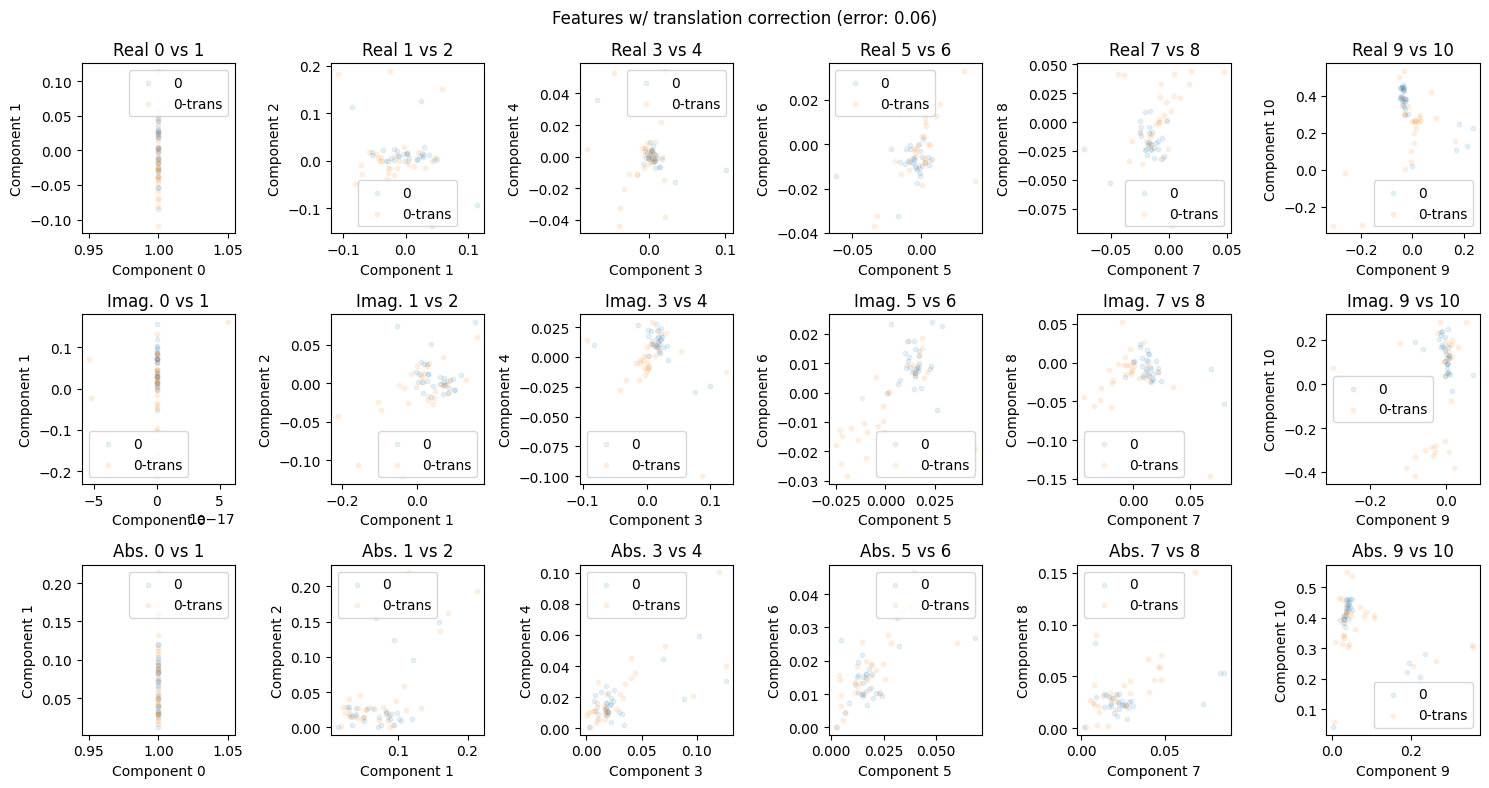

In [36]:
################################################################
############################ TEST ##############################
################################################################

feat_t_a = test_2_3_2(translation_invariant, find_contour, apply_translate, compute_descriptor_padding, linear_interpolation,images_p_a, feat_a)

* **Q3 (1 pt)**: Complet the function `rotation_invariant` to make the Fourier deciptor invariant to rotation. Does the error decrease after treatment for rotation invariance? Do you think that selecting specific rotation angles might help the error to decrease even lower?
    * **Answer**: The error decreases after treatment. Selecting specific angles would not help decrease the error further because

In [37]:
def rotation_invariant(features):
    """
    Make input Fourier descriptors invariant to rotation.

    Args
    ----
    features: np.ndarray (N, D)
        The Fourier descriptors of N images over D features.

    Return
    ------
    features_inv: np.ndarray (N, K)
        The Fourier descriptors invariant to rotation of N images 
        over K (K <= N) features.
    """

    # Set default values
    features_inv = np.zeros_like(features)
    
    # ------------------
    for i in range(len(features)):
        features_inv[i] = features[i] / features[i][0] #normalize the descriptor by the first element
    # ------------------

    return features_inv

Rotation error: 10.43
Corrected rotation error: 0.04


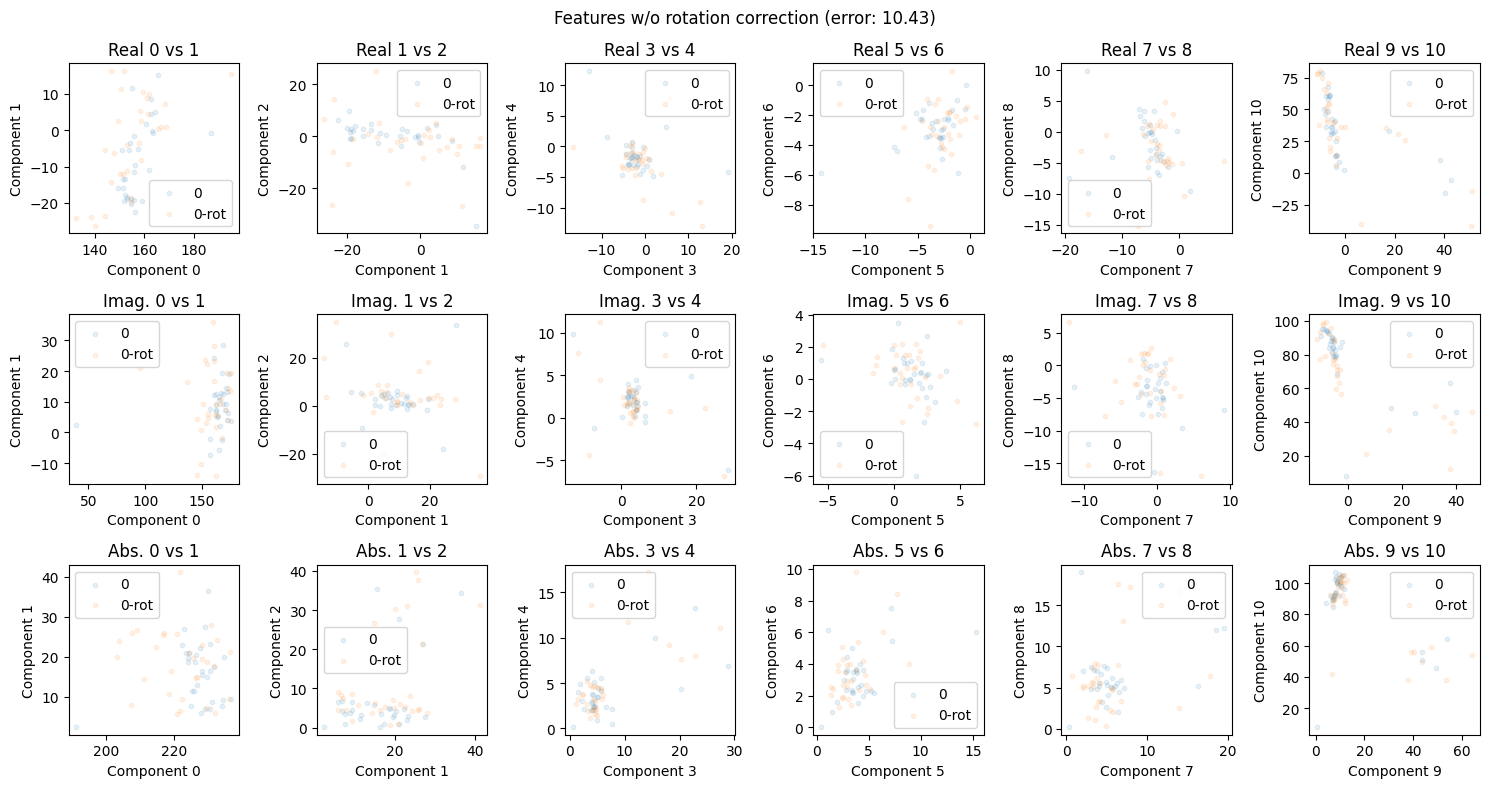

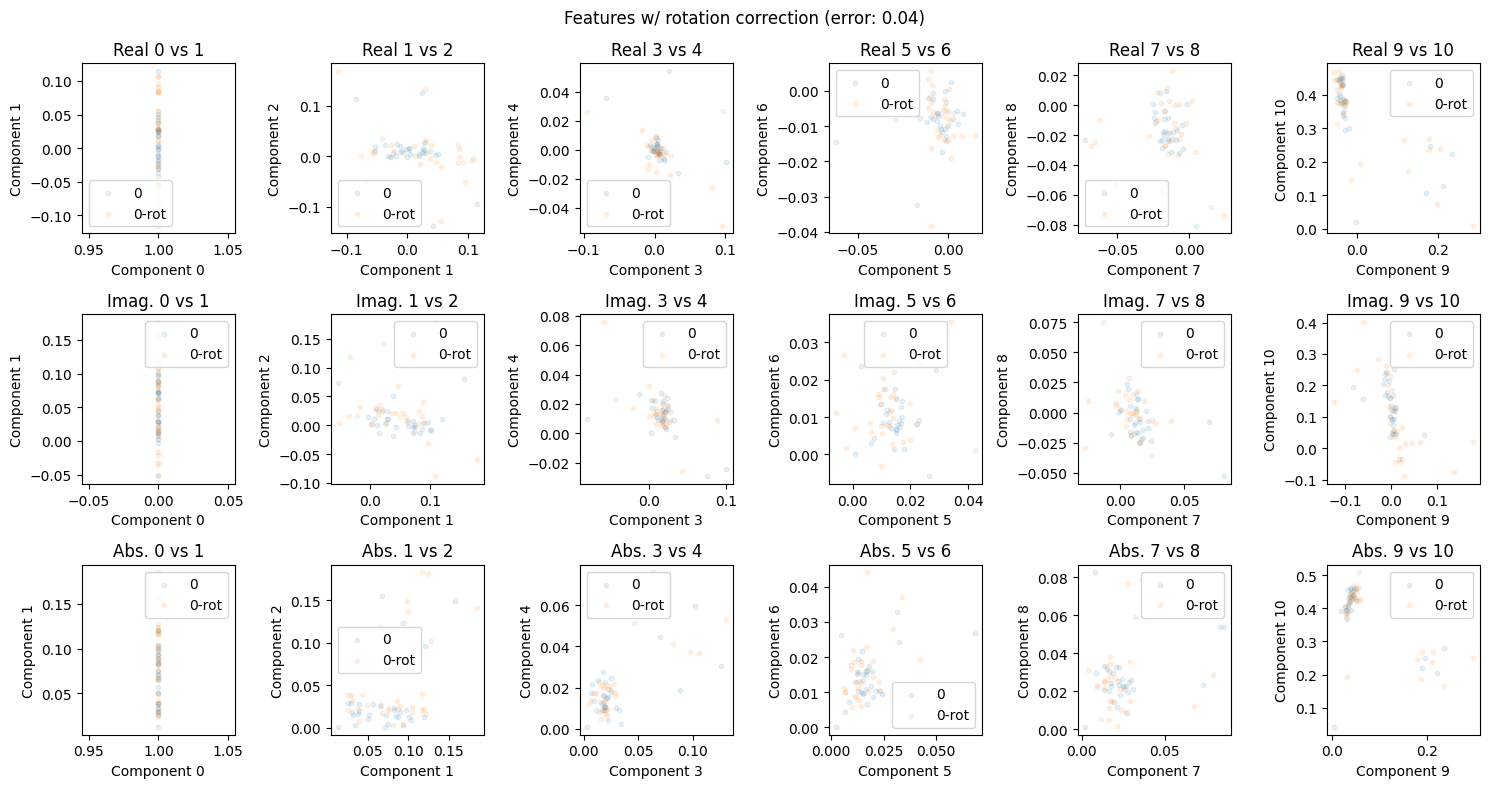

In [38]:
################################################################
############################ TEST ##############################
################################################################

test_2_3_3(rotation_invariant, find_contour, apply_rotation, compute_descriptor_padding, linear_interpolation,images_p_a, feat_a)

* **Q4 (1 pt)**: Complet the function `scaling_invariant` to make the Fourier deciptor invariant to scaling. Does the error decrease after treatment for scaling invariance? Is it null? Why?
    * **Answer**: The error decreases close to 0. It is not exactly null because

In [39]:
def scaling_invariant(features):
    """
    Make input Fourier descriptors invariant to scaling.

    Args
    ----
    features: np.ndarray (N, D)
        The Fourier descriptors of N images over D features.

    Return
    ------
    features_inv: np.ndarray (N, K)
        The Fourier descriptors invariant to scaling of N images 
        over K (K <= N) features.
    """

    # Set default values
    features_inv = np.zeros_like(features)
    
    # ------------------
    for i in range(len(features)):
        features_inv[i] = features[i] / features[i][0] #normalize the descriptor by the first element
    # ------------------

    return features_inv

Scaling error: 16.65
Corrected scaling error: 0.03


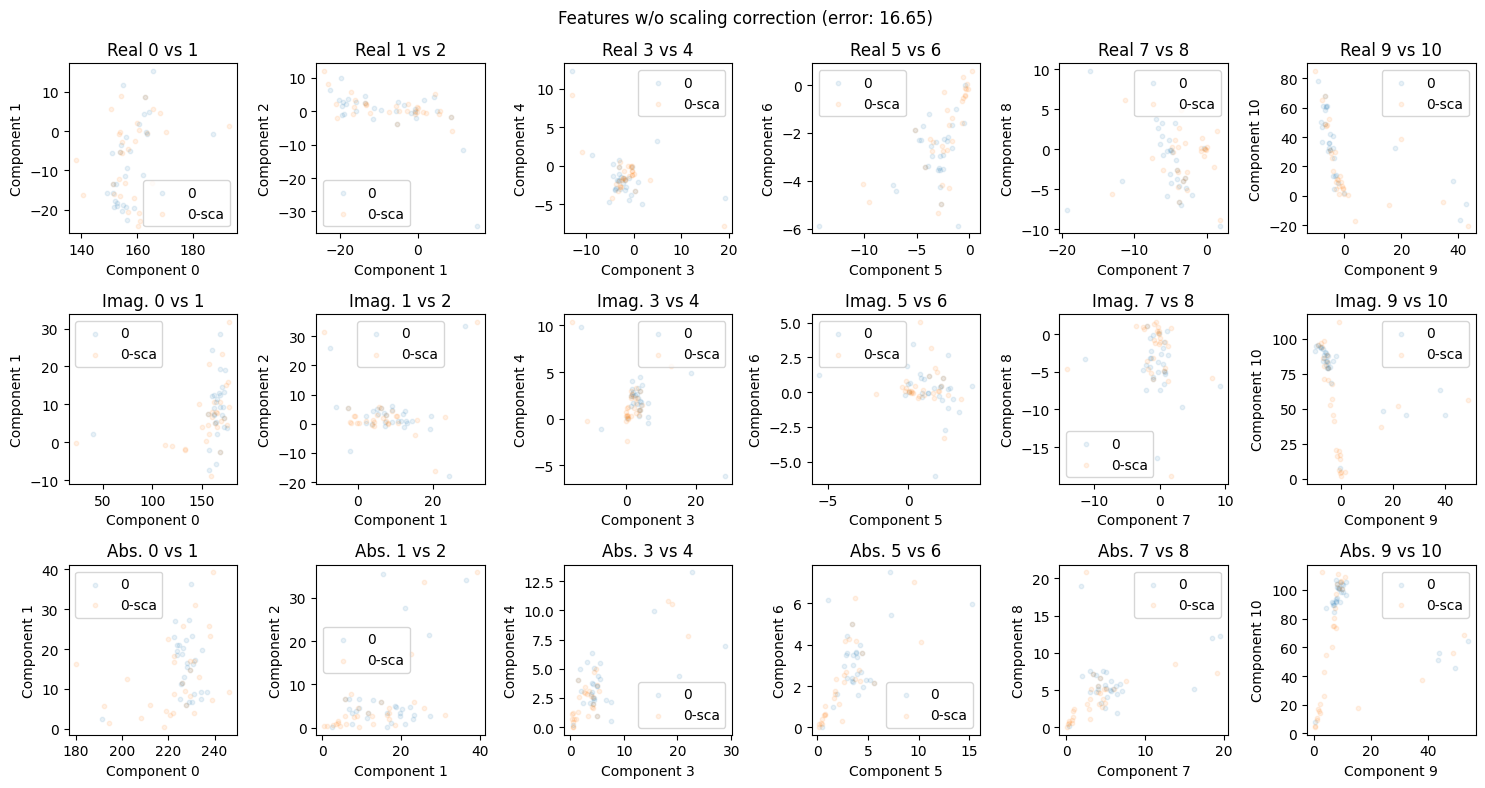

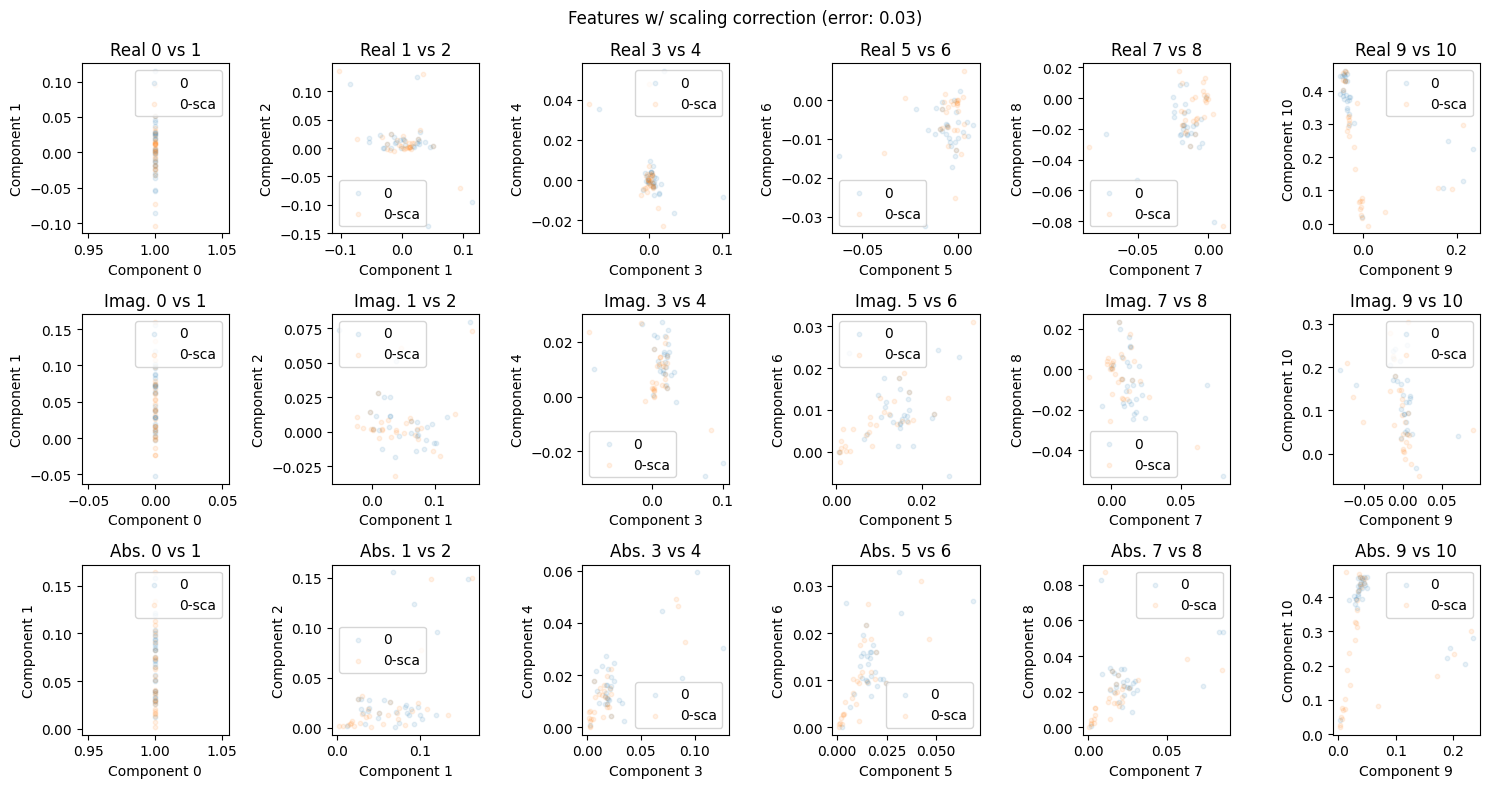

In [40]:
################################################################
############################ TEST ##############################
################################################################

test_2_3_4(scaling_invariant, find_contour, apply_scaling, compute_descriptor_padding, linear_interpolation,images_p_a, feat_t_a, feat_a)

---
# PART 3 - Other descriptors [8 pts]

## 3.1 Distance map (5 pts)

In this part, we will learn how to use a distance map as a feature descriptor. 

* **Q1 (1 pt)**: To compute a distance map we first need a reference pattern. Complete the function `reference_pattern`. The function takes as input a list of images and computes the reference pattern as the average of all shapes.

In [41]:
def reference_pattern(imgs):
    """
    Compute the reference pattern for a given set of images. The reference pattern 
    is estimated as the average of all images of the same pattern.

    Args
    ----
    imgs: np.ndarray (N, 28, 28)
        Source images
        
    Return
    ------
    pattern: np.ndarray (28, 28)
        Thresholded reference pattern that is the average of all shapes.
    """

    # Initialize pattern
    pattern = np.zeros((imgs[0].shape[0], imgs[0].shape[1]))
    
    # ------------------
    for i in range(len(imgs)):
        pattern += imgs[i]
    pattern = pattern / len(imgs)
    # ------------------
   
    return pattern

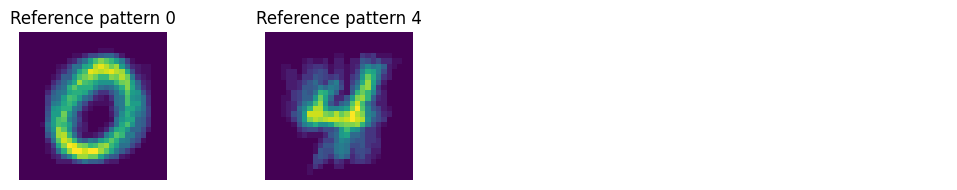

In [42]:
################################################################
############################ TEST ##############################
################################################################

pattern_a, pattern_b = test_3_1(reference_pattern, images_p_a, images_p_b)

* **Q2 (2 pts)**: The next part will be to compute a distance map from the generated pattern. By pre-computing the distance map we can speedup the inference time. Complete the function `compute_distance_map`. We expect the values of the map to represent the distances to the closest pattern contour. If needed, can take advantage of the functions you wrote in PART2 to detect and resample contours.

In [69]:
def compute_distance_map(pattern: np.ndarray):
    """
    Compute the distance map for the given pattern. The values of the map are computed as 
    the distance to the closest pattern contour.

    Args
    ----
    pattern: np.ndarray (28, 28)
        Pattern to process

    Return
    ------
    distance_map: np.ndarray (28, 28)
        Distance map where each entry is the distance to the closest pattern contour (shortest 
        distance to pattern)
    """
    
    # Initialize dummy values
    distance_map = np.zeros_like(pattern)
    
    # ------------------  
    from skimage.measure import find_contours
    contours = find_contours(pattern)
    contour = contours[0]
    for i in range(distance_map.shape[0]):
        for j in range(distance_map.shape[1]):
            # Get the distance to the closest contour
            distance_map[i, j] = np.min(np.sqrt((contour[:, 0] - i) ** 2 + (contour[:, 1] - j) ** 2))
    # ------------------
    
    return distance_map

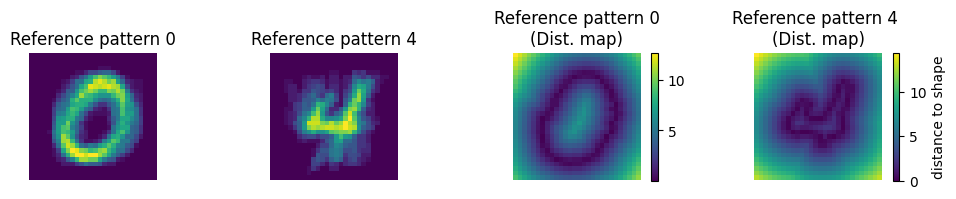

In [70]:
################################################################
############################ TEST ##############################
################################################################

map_a, map_b = test_3_1_2(compute_distance_map, pattern_a, pattern_b)

* **Q3 (2 pts)**: For the last part, implement the function `compute_distance` that uses the precomputed distance map to evaluate the distance to all images. Note that for each image you should return the average of distances. As before, for each digit, you can compute the contour and estimate the point-to-point distance by evaluating the distance map at the xy contour coordinates.

In [ ]:
def compute_distance(imgs, d_map):
    """
    Compute the distances for each image with respect to the reference pattern using the precomputed 
    distance map. The final distance is the average of all distances from the image's contour points 
    to the reference pattern.

    Args
    ----
    imgs: np.ndarray (N, 28, 28)
        Source images
    d_map: np.ndarray (28, 28)
        The precomputed distance map where each entry is the distance to the closest pattern contour 
        (shortest distance to pattern)
    
    Return
    ------
    dist: np.ndarray (N, )
        Averaged distance to pattern for each input image.
    """
    
    # Default values
    dist = np.zeros(len(imgs))

    # ------------------
    size = imgs[0].shape[0]
    for i in range(len(imgs)):
        img = imgs[i] > 0
        distances = img * d_map
        dist[i] = np.sum(distances) / (size * size) #average the distances
    # ------------------
    
    return dist
    

C:\Users\miski\AppData\Local\Temp\ipykernel_11936\3138022459.py:35: RuntimeWarning: invalid value encountered in scalar divide
  dist[i] = dist[i] / area


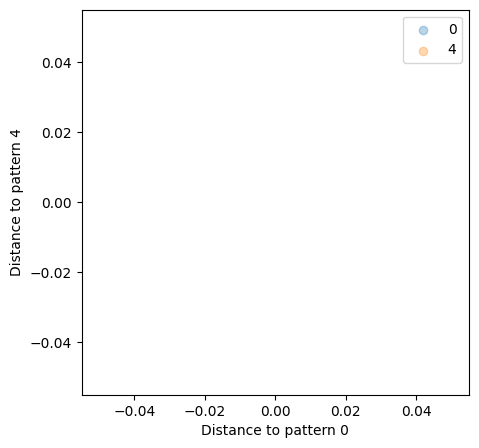

In [63]:
################################################################
############################ TEST ##############################
################################################################

test_3_1_3(compute_distance, images_p_a, images_p_b, map_a, map_b)

## 3.2 Others (3 pts)

For the last part of the lab, we will compute other various visual features. 

* **Q1: (2 pts)**: Implement the function `compute_features` that estimates the digit's perimeter, area, compacity, and rectangularity. You can use the lecture to look for the definition of each feature. To help you with this task we strongly recommend using the `regionprops` ([doc](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops)) from scikit-image.
* **Q2: (1 pt)**: Which feature(s) seem(s) to show the best results to distinguish between both digits? (justify)
    * **Answer**: It seems that there is a bigger overlap and more extreme outliers between area and perimeter than between compacity and rectangularity where the 2 clusters are clearly distinguishable.

In [ ]:
def compute_features(imgs: np.ndarray):
    """
    Compute compacity for each input image.
    
    Args
    ----
    imgs: np.ndarray (N, 28, 28)
        Source images
        
    Return
    ------
    f_peri: np.ndarray (N,)
        Estimated perimeter length for each image
    f_area: np.ndarray (N,)
        Estimated area for each image
    f_comp: np.ndarray (N,)
        Estimated compacity for each image
    f_rect: np.ndarray (N,)
        Estimated rectangularity for each image
    """

    f_peri = np.zeros(len(imgs))
    f_area = np.zeros(len(imgs))
    f_comp = np.zeros(len(imgs))
    f_rect = np.zeros(len(imgs))
    
    # ------------------
    for i in range(len(imgs)):
        img = imgs[i, :, :]
        img = img.astype(np.uint8)
        prop = regionprops(img)
        f_peri[i] = prop[0].perimeter
        f_area[i] = prop[0].area
        f_comp[i] = prop[0].perimeter**2 / prop[0].area

        bbox_area = (prop[0].bbox[3] - prop[0].bbox[1]) * (prop[0].bbox[2] - prop[0].bbox[0])
        f_rect[i] = prop[0].area / bbox_area
    # ------------------

    return f_peri, f_area, f_comp, f_rect


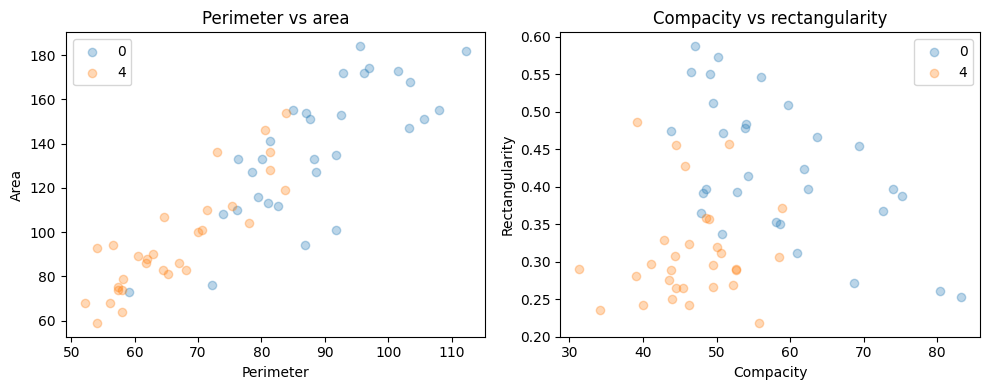

In [67]:
################################################################
############################ TEST ##############################
################################################################

test_3_2(compute_features, images_p_a, images_p_b)